# House price prediction

The purpose of this project is to predict sales prices for houses using regression techniques

## 1. Preprocessing

## 1.1. Load data, drop null values and duplicates

For now, all the columns with samples smaller than 1460 will be removed. It is possible to transform this values later.

In [186]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import train_test_split

In [187]:
df= pd.read_csv('train.csv')
df.columns = df.columns.str.lower() 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [188]:
cat_th=10 
car_th=20
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                   df[col].dtypes == "O"]
cat_cols = cat_cols + num_but_cat
cat_cols = [col for col in cat_cols if col not in cat_but_car]

# num_cols
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
num_cols = [col for col in num_cols if col not in num_but_cat]

print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f'cat_cols: {len(cat_cols)}')
print(f'num_cols: {len(num_cols)}')
print(f'cat_but_car: {len(cat_but_car)}')
print(f'num_but_cat: {len(num_but_cat)}')
    
print(f"""Categorical Variables={cat_cols},\nNumerical Variables={num_cols},\nCategorical but Cardinal Variables={cat_but_car}""")

Observations: 1460
Variables: 81
cat_cols: 53
num_cols: 27
cat_but_car: 1
num_but_cat: 11
Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'fireplaces', 'garagecars', 'poolarea', 'yrsold'],
Numerical Variables=['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'tot

<function matplotlib.pyplot.show(close=None, block=None)>

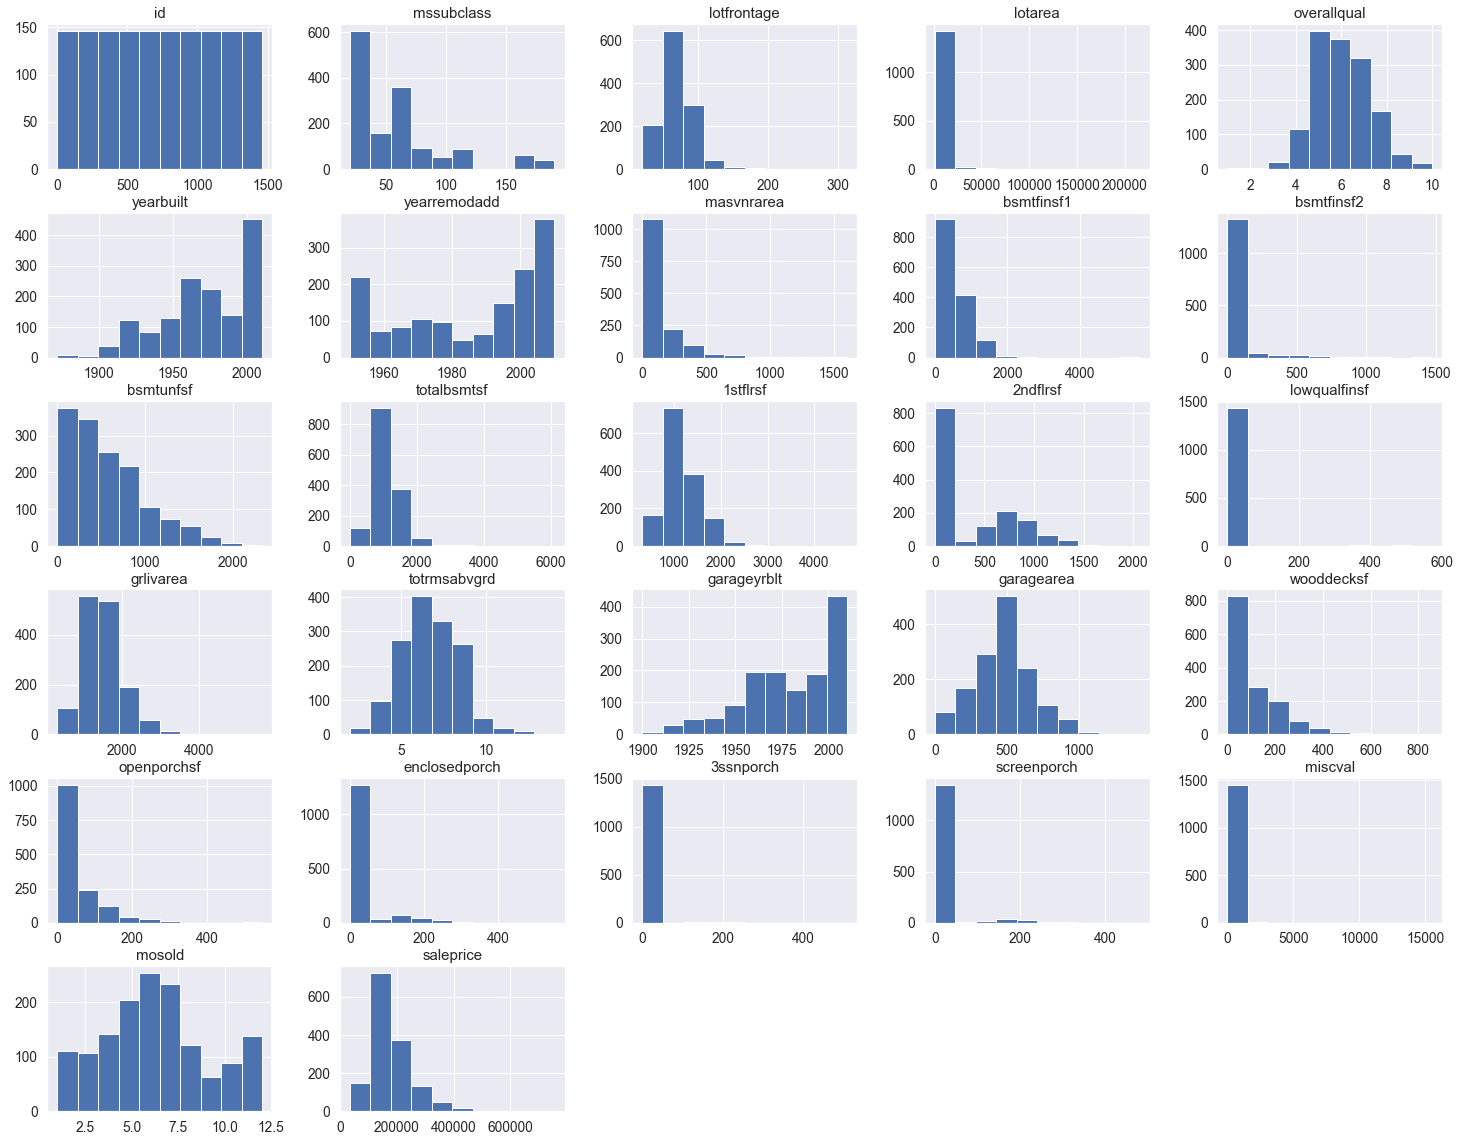

In [189]:
df[num_cols].hist(figsize=(25,20))
plt.show

In [190]:
most_null = []
for i in df.columns:
    null = df[df[i].isnull()]
    if len(null) > 0.3*len(df.index):
        most_null.append(i)
print(most_null)

['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature']


In [191]:
df[most_null] = df[most_null].fillna("None")
df[most_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   alley        1460 non-null   object
 1   fireplacequ  1460 non-null   object
 2   poolqc       1460 non-null   object
 3   fence        1460 non-null   object
 4   miscfeature  1460 non-null   object
dtypes: object(5)
memory usage: 57.2+ KB


In [192]:
#Replace with none

for col in ('garagetype', 'garagefinish', 'garagequal', 'garagecond'):
        df[col] = df[col].fillna('None')

for col in ('garageyrblt', 'garagearea', 'garagecars'):
        df[col]= df[col].fillna(0)
for col in ('bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf','totalbsmtsf', 'bsmtfullbath', 'bsmthalfbath'):
    df[col] = df[col].fillna(0)

for col in ('bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'):
    df[col] = df[col].fillna('None')



#Replace missing data with median or mode

df["lotfrontage"] = df.groupby("neighborhood")["lotfrontage"].transform(lambda x: x.fillna(x.median()))

df['mszoning'] = df['mszoning'].fillna(df['mszoning'].mode()[0])
df['electrical'] = df['electrical'].fillna(df['electrical'].mode()[0])
df['kitchenqual'] = df['kitchenqual'].fillna(df['kitchenqual'].mode()[0])
df["functional"] = df["functional"].fillna("typ")
df["masvnrtype"] = df["masvnrtype"].fillna(df["masvnrtype"].mode()[0])
df["masvnrarea"] = df["masvnrarea"].fillna(df["masvnrarea"].mode()[0])


#Drop variables
df = df.drop(['utilities'], axis=1)

In [193]:
data_na = (df.isnull().sum() / len(df)) * 100
data_na

id               0.0
mssubclass       0.0
mszoning         0.0
lotfrontage      0.0
lotarea          0.0
                ... 
mosold           0.0
yrsold           0.0
saletype         0.0
salecondition    0.0
saleprice        0.0
Length: 80, dtype: float64

In [194]:
all_data_na = (df.isnull().sum() / len(df)) * 100


In [195]:
#MSSubClass=The building class
df['mssubclass'] = df['mssubclass'].apply(str)


#Changing OverallCond into a categorical variable
df['overallcond'] = df['overallcond'].astype(str)


#Year and month sold are transformed into categorical features.
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)


#update features group
update_group = ['mssubclass', 'overallcond', 'yrsold', 'mosold']
for i in update_group:
    cat_cols.append(i)


print(f"Categorical Variables={cat_cols}")

Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'fireplaces', 'garagecars', 'poolarea', 'yrsold', 'mssubclass', 'overallcond', 'yrsold', 'mosold']


In [196]:
cat_cols.remove('utilities')
print(f"Categorical Variables={cat_cols}")

Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'fireplaces', 'garagecars', 'poolarea', 'yrsold', 'mssubclass', 'overallcond', 'yrsold', 'mosold']


In [197]:
sale_price = df['saleprice']
area = df['grlivarea']
price_per_sqft = sale_price/area

df['price_per_sqft'] = price_per_sqft

print(f"All columns={df.columns}")

All columns=Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', '1stflrsf', '2ndflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive'

In [198]:
df_clean = df.drop(['saleprice', '1stflrsf', '2ndflrsf', 'grlivarea', 
                    'id', 'neighborhood'], axis=1)
print(f"All columns={df_clean.columns}")

All columns=Index(['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'lotconfig', 'landslope', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual', 'extercond',
       'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1',
       'bsmtfinsf1', 'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
       'heating', 'heatingqc', 'centralair', 'electrical', 'lowqualfinsf',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd', 'functional',
       'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive', 'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch',
     

<AxesSubplot:>

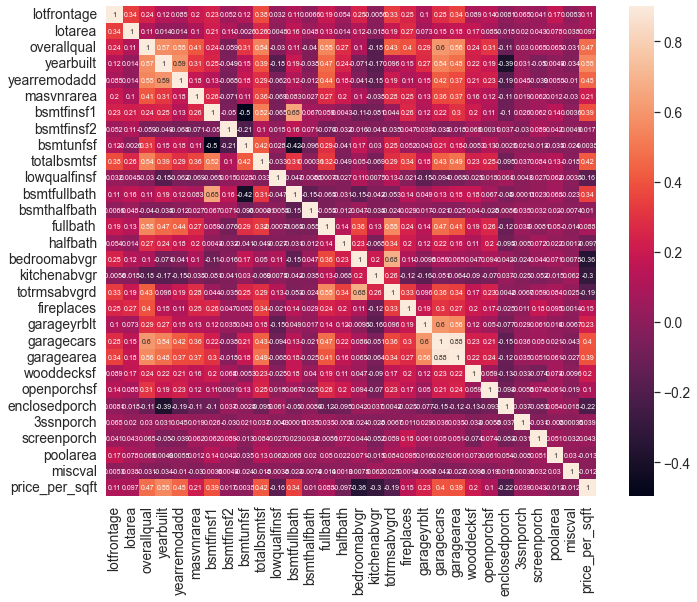

In [199]:
corrmat = df_clean.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True, annot_kws={'size': 7})

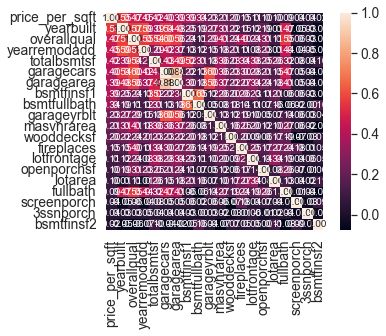

In [200]:
k = 20 #number of variables for heatmap

cols =corrmat.nlargest(k, 'price_per_sqft')['price_per_sqft'].index

cm =np.corrcoef(df_clean[cols].values.T)

sns.set(font_scale=1.25)

hm =sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

plt.show()

In [201]:
print("Find most important features relative to target")
corr = df_clean.corr()
corr.sort_values(["price_per_sqft"], ascending = True, inplace = True)

print(corr.price_per_sqft)
 

Find most important features relative to target
bedroomabvgr     -0.355970
kitchenabvgr     -0.301895
enclosedporch    -0.216942
totrmsabvgrd     -0.186928
lowqualfinsf     -0.159051
halfbath         -0.097079
poolarea         -0.013320
miscval          -0.012039
bsmtunfsf         0.003849
bsmthalfbath      0.010476
bsmtfinsf2        0.016556
3ssnporch         0.038848
screenporch       0.042951
fullbath          0.087906
lotarea           0.096957
openporchsf       0.100935
lotfrontage       0.113601
fireplaces        0.147418
wooddecksf        0.200049
masvnrarea        0.209652
garageyrblt       0.229679
bsmtfullbath      0.342586
bsmtfinsf1        0.392853
garagearea        0.394410
garagecars        0.401951
totalbsmtsf       0.418392
yearremodadd      0.448556
overallqual       0.473772
yearbuilt         0.554921
price_per_sqft    1.000000
Name: price_per_sqft, dtype: float64


In [202]:
#low_corr = ['poolarea', 'miscval', 'bsmtunfsf', 'bsmthalfbath', 'bsmtfinsf2', 'garagearea']
#df_clean = df_clean.drop(low_corr, axis=1)


#cat_cols.remove(['miscval', 'bsmtunfsf', 'bsmthalfbath', 'bsmtfinsf2'])

ValueError: list.remove(x): x not in list

In [ ]:
def encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_clean = encoder(df_clean,cat_cols,drop_first=True)


KeyError: "['bsmthalfbath', 'poolarea'] not in index"

In [ ]:
pd.set_option('display.max_columns',None)
print(df_clean.describe().T)

               count          mean          std     min     25%     50%  \
lotfrontage   1460.0     70.199658    22.431902    21.0    60.0    70.0   
lotarea       1460.0  10516.828082  9981.264932  1300.0  7553.5  9478.5   
overallqual   1460.0      6.099315     1.382997     1.0     5.0     6.0   
yearbuilt     1460.0   1971.267808    30.202904  1872.0  1954.0  1973.0   
yearremodadd  1460.0   1984.865753    20.645407  1950.0  1967.0  1994.0   
...              ...           ...          ...     ...     ...     ...   
mosold_5      1460.0      0.139726     0.346821     0.0     0.0     0.0   
mosold_6      1460.0      0.173288     0.378625     0.0     0.0     0.0   
mosold_7      1460.0      0.160274     0.366986     0.0     0.0     0.0   
mosold_8      1460.0      0.083562     0.276824     0.0     0.0     0.0   
mosold_9      1460.0      0.043151     0.203266     0.0     0.0     0.0   

                  75%       max  
lotfrontage      80.0     313.0  
lotarea       11601.5  215245.0

In [ ]:
y = df_clean['price_per_sqft']
X = df_clean.drop(['price_per_sqft'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1095, 301) (365, 301)
(1095,) (365,)


In [ ]:
df_clean.isnull().values.any()

False

In [ ]:
regr = LinearRegression() #create a regression object
regr.fit(X_train, y_train) #train the model

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
houseprice_y_pred = regr.predict(X_test) #make prediction
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, houseprice_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, houseprice_y_pred))

Coefficients: 
 [-1.66017757e-02  2.73326448e-04  3.78974151e+00  3.75443239e-01
  6.46737504e-02  7.77213176e-03  1.82059982e-03  2.48535191e-03
 -8.77202210e-03 -4.46606164e-03 -9.13176826e-03 -3.22689894e+00
  1.34569343e-02  3.91238407e-03  8.32444235e-03  1.67241207e-03
 -6.45597481e-04  1.34133932e-02  2.62431768e-02  3.83563281e-03
  2.93113365e+01  1.25399146e+01  2.27872319e+01  1.57607082e+01
  1.01365998e+01  4.33281436e-02  7.96956843e-01  4.40972289e+00
  2.42181106e+00  3.78162723e-01  1.19879883e+01  5.09887675e+00
  2.31895485e+00  2.39529885e+00 -4.30695704e+00 -5.07390130e+00
 -1.62756024e+00 -2.90561277e+00 -2.61390992e+01  6.92884270e+00
  1.14194240e+01 -5.42745677e+00  8.36763362e+00 -1.92868849e+00
  1.34195174e+01  6.21227149e+00  1.78354964e+01 -1.33370158e+01
 -8.63301863e-01 -4.56612526e-12 -8.09762568e+01 -1.51419971e+01
 -8.12728098e+00 -1.73994152e-12 -6.45288973e+00 -5.96438713e+00
 -1.50910197e-01  1.41190314e+00  1.33194537e+01  6.76404642e+00
 -9.62575

In [ ]:
#create models

models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor())]
          #("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 18.9323 (LR) 
RMSE: 17.1406 (Ridge) 
RMSE: 19.6953 (Lasso) 
RMSE: 20.1591 (ElasticNet) 
RMSE: 27.1566 (KNN) 
RMSE: 24.3504 (CART) 
RMSE: 17.5935 (RF) 
RMSE: 30.75 (SVR) 
RMSE: 17.4796 (GBM) 
